# Creating Decision Tree Classifier from Scratch

Making the ID3 Decision Tree algorithm using entropy from scratch. The zoo data is from http://archive.ics.uci.edu/ml/datasets/zoo.

Begin by first importing any useful or frequently used dependencies, followed by reading the zoo.csv file.

In [10]:
import pandas as pd
import numpy as np
from pprint import pprint
import io

dataset = pd.read_csv('zoo_data.csv',index_col=0)
dataset.head()

,animal_name,hair,feathers,eggs,milk,airbone,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class
0,aardvark,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
1,antelope,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1
2,bass,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
3,bear,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
4,boar,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1


The animal_name column will be removed as it is simply an identifier which will not provide useful information to this implementation.

In [11]:
# remove animal names column, as bad feature to split data on
dataset=dataset.drop('animal_name',axis=1)

Reusable functions are created for the calculation of entropy and information gain as noted by the ID3 algorithm.

Entropy is the measure of the amount of uncertainty and information gain is the measure of the difference in entropy from before to after the data is split on an attribute/feature. https://en.wikipedia.org/wiki/ID3_algorithm

In [12]:
# calculate entropy
def compute_entropy(samples):
    if len(samples) < 2:
        return 0
    freq = np.array(samples.value_counts(normalize=True))
    return -(freq * np.log2(freq + 1e-6)).sum()

# calculate information gain
def info_gain(data, attr, target):
    values = data[attr].value_counts(normalize=True)
    split_ent = 0
    for value, count in values.iteritems():
        idx = data[attr] == value
        sub_ent = compute_entropy(target[idx])
        split_ent += count * sub_ent
    ent = compute_entropy(target)
    return ent - split_ent

In [13]:
# tree implementation
class TreeNode:
    # recursively defined data structure to store tree
    # each node contains other nodes as children
    def __init__(self, node="", min_sample=1, default_decision=None):
        self.children = {} # sub nodes
        self.decision = None # undecided
        self.split_feat = None # splitting feature
        self.name = node
        self.default_decision = default_decision
        self.min_sample = min_sample

    # pretty print function
    def pretty_print(self, prefix=''):
        if self.split_feat is not None:
            for each, value in self.children.items():
                value.pretty_print(f"{prefix}:When {self.split_feat} is {each}")
        else:
            print(f"{prefix}:{self.decision}")

    # predict function
    def predict(self, data):
        if self.decision is not None:
            # uncomment to debug, view more details
            # print("Decision:", self.decision)
            return self.decision
        else:
            attr_val = data[self.split_feat]
            if self.children.get(attr_val) is None:
                return self.decision
            child = self.children[attr_val]
            # uncomment to debug, view more details
            # print("Testing ", self.split_feat, "->", attr_val)
            return child.predict(data)

    # fit data to model
    def fit(self, data, target):
        # function accepts training dataset
        # from which a tree is built to make decisions or to make children nodes
        # set prediction to mode if decision is none
        if self.default_decision is None:
            self.default_decision = target.mode()[0]
        # uncomment to debug, view more details
        # print(self.name, "received", len(data), "samples")
        # if length of data is less than specified min sample, make decision
        if len(data) < self.min_sample:
        # if data is empty, arbitrary decision is made
            if len(data) == 0:
                self.decision = self.default_decision
                # uncomment to debug, view more details
                # print("Decision: ", self.decision)
                # else mode is used
            else:
                self.decision = target.mode()[0]
                # uncomment to debug, view more details
                # print("Decision: ", self.decision)
            return
        else:
            unique_values = target.unique()
            # if only 1 unique prediction in target, make decision the target
            if len(unique_values) == 1:
                self.decision = unique_values[0]
                # uncomment to debug, view more details
                # print("Decision: ", self.decision)
                return
            else:
                # select split feature
                info_gain_max = 0
                for attr in data.keys(): # examine each attribute
                    attr_ig = info_gain(data, attr, target)
                    if attr_ig > info_gain_max:
                        info_gain_max = attr_ig
                        self.split_feat = attr
                # uncomment to debug, view more details
                # print(f"Split by {self.split_feat}, IG: {info_gain_max:.2f}")
                self.children = {}
                for value in data[self.split_feat].unique():
                    idx = data[self.split_feat] == value
                    self.children[value] = TreeNode(node=self.name + ":" + self.split_feat + "==" + str(value),
                                                    min_sample=self.min_sample,
                                                    default_decision=self.default_decision)
                    self.children[value].fit(data[idx], target[idx])

In [14]:
# Test tree building

from sklearn.model_selection import train_test_split

data = dataset.drop(["class"], axis=1)
target = dataset["class"]

X_train, X_test, Y_train, Y_test = train_test_split(data, target, train_size=0.7, random_state=1)

# min samples can be adjusted based on tolerance of data samples
clf = TreeNode(min_sample=1)
clf.fit(X_train, Y_train)


In [15]:
# view decision tree and the features it splits on
clf.pretty_print()

:When legs is 0:When fins is 1:When eggs is 1:4
:When legs is 0:When fins is 1:When eggs is 0:1
:When legs is 0:When fins is 0:When toothed is 0:7
:When legs is 0:When fins is 0:When toothed is 1:3
:When legs is 2:When hair is 1:1
:When legs is 2:When hair is 0:2
:When legs is 4:When hair is 1:1
:When legs is 4:When hair is 0:When aquatic is 0:3
:When legs is 4:When hair is 0:When aquatic is 1:When toothed is 1:5
:When legs is 4:When hair is 0:When aquatic is 1:When toothed is 0:7
:When legs is 8:7
:When legs is 6:When aquatic is 0:6
:When legs is 6:When aquatic is 1:7


In [16]:
# measuring accuracy and validating performance

def accuracy(data, targ):
    count = 0
    for (i, ct), target in zip(data.iterrows(), targ):
        prediction = clf.predict(ct)
        if prediction == target:
            count += 1
    return round(count/len(targ), 4)

print("Training accuracy: ", accuracy(X_train, Y_train))
print("Validating accuracy: ", accuracy(X_test, Y_test))

Training accuracy:  1.0
Validating accuracy:  0.9677


In [17]:
# view issue with prediction

print(sorted(X_train['legs'].unique()))
print(sorted(X_test['legs'].unique()))

[0, 2, 4, 6, 8]
[0, 2, 4, 5, 6]


From investigating the unique values in the number of legs column, we can see that the model is tested on an animal with 5 legs which was not present in the training set and is likely why an error has been produced.

We can also visualise the effects of adjusting the min_sample parameter

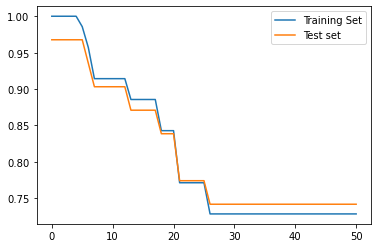

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# used to inspect accuracy as min sample restriction increases
train_sample_accuracy = []
test_sample_accuracy = []
best_param = 0
for i in range(0,51):
    clf = TreeNode(min_sample=i)
    clf.fit(X_train, Y_train)
    train_sample_accuracy.append(accuracy(X_train, Y_train))
    test_sample_accuracy.append(accuracy(X_test, Y_test))

merged = [train_sample_accuracy] + [test_sample_accuracy]
#sns.lineplot(data=(merged)) - won't work in kaggle :(
sns.lineplot(data=np.array(train_sample_accuracy), label="Training Set")
sns.lineplot(data=np.array(test_sample_accuracy), label="Test set")
plt.show()

In [22]:
merged

[[1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.9857,
  0.9571,
  0.9143,
  0.9143,
  0.9143,
  0.9143,
  0.9143,
  0.9143,
  0.8857,
  0.8857,
  0.8857,
  0.8857,
  0.8857,
  0.8429,
  0.8429,
  0.8429,
  0.7714,
  0.7714,
  0.7714,
  0.7714,
  0.7714,
  0.7286,
  0.7286,
  0.7286,
  0.7286,
  0.7286,
  0.7286,
  0.7286,
  0.7286,
  0.7286,
  0.7286,
  0.7286,
  0.7286,
  0.7286,
  0.7286,
  0.7286,
  0.7286,
  0.7286,
  0.7286,
  0.7286,
  0.7286,
  0.7286,
  0.7286,
  0.7286,
  0.7286,
  0.7286,
  0.7286,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.9857,
  0.9571,
  0.9143,
  0.9143,
  0.9143,
  0.9143,
  0.9143,
  0.9143,
  0.8857,
  0.8857,
  0.8857,
  0.8857,
  0.8857,
  0.8429,
  0.8429,
  0.8429,
  0.7714,
  0.7714,
  0.7714,
  0.7714,
  0.7714,
  0.7286,
  0.7286,
  0.7286,
  0.7286,
  0.7286,
  0.7286,
  0.7286,
  0.7286,
  0.7286,
  0.7286,
  0.7286,
  0.7286,
  0.7286,
  0.7286,
  0.7286,
  0.7286,
  0.7286,
  0.7286,
  0.7286,
  0.7286,
  0.7286,
  0.7286,
  0.7286,
  0.7286,
  0.7286],

Unsurprisingly, the more minimum samples that are required to generate a split will lower the accuracy of the model. Although accuracy is reduced, this feature is still useful when you want to discard attributes with very little samples.